# IMPORTS

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer

pd.set_option('display.max_columns', None)

# DATA

In [6]:
df = pd.read_csv("raw_data/FC26_20250921.csv", low_memory=False)

In [104]:
# In-game 'boost' columns not relevant
drop_cols = df.columns[-28:-1]
df = df.drop(columns=drop_cols)

# Work rate column is empty. Drop work rate column
df = df.drop(columns=['work_rate'])

# Take the first given position as a player's primary position (new column)
df['primary_position'] = df['player_positions'].str.split(',').str[0]

# Map primary position to broader groups
position_groups = {
    'ST': 'Forward', 'CF': 'Forward', 'LW': 'Forward', 'RW': 'Forward',
    'CAM': 'Midfielder', 'CM': 'Midfielder', 'CDM': 'Midfielder', 'LM': 'Midfielder', 'RM': 'Midfielder',
    'CB': 'Defender', 'LB': 'Defender', 'RB': 'Defender', 'LWB': 'Defender', 'RWB': 'Defender',
    'GK': 'Goalkeeper'
}

df['position_group'] = df['primary_position'].map(position_groups)


In [106]:
df['position_group'].unique()

array(['Midfielder', 'Defender', 'Forward', 'Goalkeeper'], dtype=object)

In [92]:
player_id = 210257

In [93]:
player_is_goalkeeper = df[df['player_id'] == player_id]['player_positions'] == 'GK'

# FEATURES

In [ ]:

all_features = ['player_positions',
       'overall', 'potential', 'value_eur', 'wage_eur', 'age', 'dob',
       'height_cm', 'weight_kg', 'league_id', 'league_name', 'league_level',
       'club_team_id', 'club_name', 'club_position', 'club_jersey_number',
       'club_loaned_from', 'club_joined_date',
       'club_contract_valid_until_year', 'nationality_id', 'nationality_name',
       'nation_team_id', 'nation_position', 'nation_jersey_number',
       'preferred_foot', 'weak_foot', 'skill_moves',
       'international_reputation', 'body_type', 'real_face',
       'release_clause_eur', 'player_tags', 'player_traits', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed']
# Choose features from here
# Numerical features will be MinMaxScaled
# Categorical features will be OHE

In [95]:
gk_features = ['goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed',
       'mentality_penalties', 'mentality_composure', 'age'] # Could leave out speed, pens and composure


# outfield_features = [''overall' ,pace, shooting... ]

In [71]:
outfield_features = ['attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle', 'age']

# PREPROC

In [ ]:
# Can we generate good valuation prediction models for each positional group
# Models that has a high R2 score and doesn't overfit
# Models that have sensible inputs (10 features or under?)

#### ARCHIVE

In [97]:
# # One Hot Encode categorical features
# # OHE player primary positions
# ohe = OneHotEncoder(sparse_output=False)
# ohe.fit(player_features_df[['primary_position']])
# player_features_df[ohe.get_feature_names_out()] = ohe.transform(player_features_df[['primary_position']])

# # OHE player preffered foot
# ohe = OneHotEncoder(sparse_output=False)
# ohe.fit(player_features_df[['preferred_foot']])
# player_features_df[ohe.get_feature_names_out()] = ohe.transform(player_features_df[['preferred_foot']])

# # Drop the original categorical columns
# player_features_df = player_features_df.drop(columns=categorical_columns)

# # Fill in NaNs

# # 0 for goalkeeping speed for all outfield players
# player_features_df['goalkeeping_speed'] = player_features_df['goalkeeping_speed'].fillna(0)

# # 0 for grouped outfield attribute scores for goalkeepers
# columns_to_fill = ['pace', 'physic', 'defending', 'passing', 'shooting', 'dribbling']
# player_features_df[columns_to_fill] = player_features_df[columns_to_fill].fillna(0)

# # Assign features df to X
# X = player_features_df.copy()
# # X.set_index('player_id', inplace=True) # with player ID as the index
# X = X.drop(columns=['player_id']) # remove player ID

#### CURRENT

#### OUTFIELD

In [98]:
outfield_mask = df['primary_position'] != 'GK'
outfield_df = df[outfield_mask]

X = outfield_df[outfield_features]
y = outfield_df['value_eur']

# MinMax scale numerical features
mm_scaler = MinMaxScaler()
X_scaled = pd.DataFrame(mm_scaler.fit_transform(X), columns=X.columns)

In [98]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
def get_data(pos_group: str="Forward"):
    df = pd.read_csv("raw_data/FC26_20250921.csv", low_memory=False)
    to_drop = [
        'wage_eur', 'player_id', 'player_url', 'fifa_version', 'fifa_update',
        'fifa_update_date', 'short_name', 'long_name', 'dob', 'league_id',
        'club_contract_valid_until_year', 'nationality_name', 'real_face', 'player_tags', 'player_face_url'
    ]
    may_drop = ['goalkeeping_speed', 'work_rate', 'release_clause_eur', 'club_team_id']
    none_num = ['league_name', 'club_name', 'club_position', 'club_loaned_from', 'club_joined_date', 'nation_position', 'body_type', 'player_traits']
    df1 = df.drop(columns=to_drop + may_drop + none_num)
    df1['primary_position'] = df1['player_positions'].str.split(',').str[0]
    position_groups = {
        'ST': 'Forward', 'CF': 'Forward', 'LW': 'Forward', 'RW': 'Forward',
        'CAM': 'Midfielder', 'CM': 'Midfielder', 'CDM': 'Midfielder', 'LM': 'Midfielder', 'RM': 'Midfielder',
        'CB': 'Defender', 'LB': 'Defender', 'RB': 'Defender', 'LWB': 'Defender', 'RWB': 'Defender',
        'GK': 'Goalkeeper'
    }
    df1['position_group'] = df1['primary_position'].map(position_groups)
    pos_drop = ['player_positions', 'position_group', 'primary_position']
    position_rating_tags = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']
    for tag in position_rating_tags:
        df1[tag] = df1[tag].map(lambda x: eval(x))
    df1['preferred_foot'] = df1.preferred_foot.map(lambda x: 1 if x == 'Left' else -1)
    res = df1[df1.position_group==pos_group].drop(columns=pos_drop)
    res.fillna(res.mean(numeric_only=True), inplace=True)
    res_y = res.value_eur
    res_X = res.drop(columns=['value_eur'])
    mm = MinMaxScaler()
    scaled_X = pd.DataFrame(mm.fit_transform(res_X), columns=res_X.columns)

    return scaled_X, res_y

In [99]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def get_features(X, y):
    pca = PCA(n_components=None, random_state=42)
    pca.fit(X)
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)],
        index=X.columns
    )

    explained = pca.explained_variance_ratio_
    importance = (np.abs(loadings) * explained).sum(axis=1)
    importance = importance / importance.sum()

    top10 = importance.sort_values(ascending=False).head(10)
    print("Top 10 important features from PCA:\n")
    print(top10)

    plt.figure(figsize=(10,4))
    top10.plot(kind='bar', color='skyblue')
    plt.title("Top 10 Feature Importances from PCA Loadings")
    plt.ylabel("Weighted contribution")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

(       overall  potential       age  height_cm  weight_kg  league_level  \
 0     0.863636   0.800000  0.666667   0.425532   0.260870           0.0   
 1     0.909091   0.911111  0.333333   0.297872   0.347826           0.0   
 2     0.931818   0.911111  0.259259   0.468085   0.217391           0.0   
 3     0.977273   0.911111  0.444444   0.468085   0.260870           0.0   
 4     0.931818   0.866667  0.407407   0.382979   0.369565           0.0   
 ...        ...        ...       ...        ...        ...           ...   
 3358  0.068182   0.511111  0.074074   0.680851   0.543478           0.0   
 3359  0.022727   0.266667  0.185185   0.361702   0.217391           0.0   
 3360  0.045455   0.177778  0.259259   0.617021   0.282609           0.0   
 3361  0.022727   0.533333  0.037037   0.617021   0.260870           0.0   
 3362  0.022727   0.244444  0.037037   0.510638   0.217391           0.0   
 
       club_jersey_number  nationality_id  nation_team_id  \
 0               0.051546

#### ATTACKERS

In [3]:
import pandas as pd
df = pd.read_csv("raw_data/FC26_20250921.csv", low_memory=False)

In [51]:
to_drop = ['wage_eur', 'player_id', 'player_url', 'fifa_version', 'fifa_update', 'fifa_update_date', 'short_name', 'long_name', 'dob', 'league_id', 'club_contract_valid_until_year', 'nationality_name', 'real_face', 'player_tags', 'player_face_url']
df1 = df.drop(columns=to_drop)

In [52]:
df1['primary_position'] = df1['player_positions'].str.split(',').str[0]
position_groups = {
    'ST': 'Forward', 'CF': 'Forward', 'LW': 'Forward', 'RW': 'Forward',
    'CAM': 'Midfielder', 'CM': 'Midfielder', 'CDM': 'Midfielder', 'LM': 'Midfielder', 'RM': 'Midfielder',
    'CB': 'Defender', 'LB': 'Defender', 'RB': 'Defender', 'LWB': 'Defender', 'RWB': 'Defender',
    'GK': 'Goalkeeper'
}

df1['position_group'] = df1['primary_position'].map(position_groups)

In [53]:
from sklearn.preprocessing import MultiLabelBinarizer

In [54]:
df2 = df1[df1.position_group == 'Forward']

In [55]:
positions_ml_data = df2.player_positions.map(lambda x: [y.strip() for y in x.split(',')])
positions_mlb = MultiLabelBinarizer()
positions_encoded_positions = positions_mlb.fit_transform(positions_ml_data)

In [56]:
import numpy as np
traits_ml_data = df2.player_traits.map(lambda x: [y.strip() for y in x.split(',')] if x is not np.nan else [])
traits_mlb = MultiLabelBinarizer()
traits_encoded_traits = traits_mlb.fit_transform(traits_ml_data)

In [57]:
df2_drop = ['player_positions', 'position_group', 'primary_position', 'goalkeeping_speed', 'work_rate', 'release_clause_eur', 'club_team_id']
df3 = df2.drop(columns=df2_drop)

In [58]:
position_rating_tags = ['ls', 'st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb', 'gk']

In [59]:
for tag in position_rating_tags:
    df3[tag] = df3[tag].map(lambda x: eval(x))

#### Look into these features later, might be useful

In [60]:

none_num = ['league_name', 'club_name', 'club_position', 'club_loaned_from', 'club_joined_date', 'nation_position', 'body_type', 'player_traits']
df4 = df3.drop(columns=none_num)

In [61]:
df4['preferred_foot'] = df4.preferred_foot.map(lambda x: 1 if x == 'Left' else -1)

In [62]:
from sklearn.preprocessing import MinMaxScaler
attacker_y = df4['value_eur']
attacker_X = df4.drop(columns=['value_eur'])
attacker_X.fillna(df.mean(numeric_only=True), inplace=True)
attacker_mm = MinMaxScaler()
attacker_scaled_X = pd.DataFrame(attacker_mm.fit_transform(attacker_X), columns=attacker_X.columns)

Top 10 important features from PCA:

mentality_aggression           0.043700
defending_standing_tackle      0.039063
power_strength                 0.038852
attacking_crossing             0.038436
power_jumping                  0.038356
mentality_interceptions        0.037320
skill_long_passing             0.037201
defending_marking_awareness    0.036784
defending_sliding_tackle       0.036433
mentality_composure            0.036223
dtype: float64


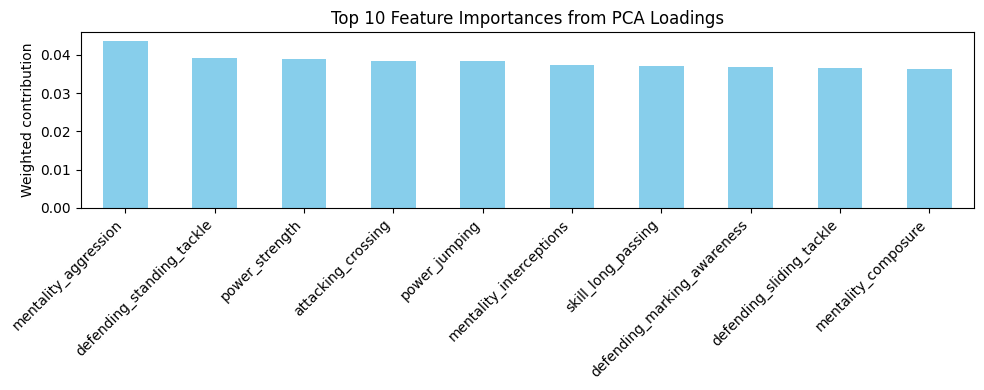

In [73]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pca = PCA(n_components=None, random_state=42)
pca.fit(attacker_scaled_X[outfield_features])

loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=attacker_scaled_X[outfield_features].columns
)

explained = pca.explained_variance_ratio_
importance = (np.abs(loadings) * explained).sum(axis=1)
importance = importance / importance.sum()

top10 = importance.sort_values(ascending=False).head(10)
print("Top 10 important features from PCA:\n")
print(top10)

plt.figure(figsize=(10,4))
top10.plot(kind='bar', color='skyblue')
plt.title("Top 10 Feature Importances from PCA Loadings")
plt.ylabel("Weighted contribution")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [76]:
pca_selected_features = list(top10.keys())
pca_selected_features

['mentality_aggression',
 'defending_standing_tackle',
 'power_strength',
 'attacking_crossing',
 'power_jumping',
 'mentality_interceptions',
 'skill_long_passing',
 'defending_marking_awareness',
 'defending_sliding_tackle',
 'mentality_composure']

In [104]:
attacker_corrs = attacker_scaled_X[['age',
            'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic',
            'skill_moves', 'weak_foot']].apply(lambda col: col.corr(attacker_y))
top10 = attacker_corrs.abs().sort_values(ascending=False).head(10)

<Axes: >

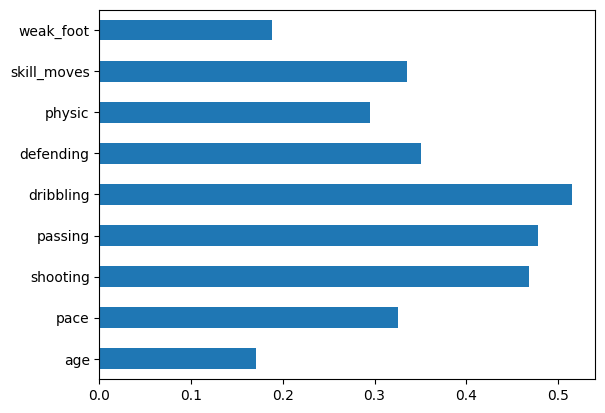

In [107]:
attacker_corrs.plot(kind='barh')

In [83]:
corr_features = list(top10.keys())
corr_features

['skill_dribbling',
 'skill_ball_control',
 'mentality_vision',
 'mentality_composure',
 'attacking_short_passing',
 'mentality_positioning',
 'attacking_finishing',
 'skill_curve',
 'power_shot_power',
 'power_long_shots']

In [89]:
all_features = list(attacker_X.columns)
all_features

['overall',
 'potential',
 'age',
 'height_cm',
 'weight_kg',
 'league_level',
 'club_jersey_number',
 'nationality_id',
 'nation_team_id',
 'nation_jersey_number',
 'preferred_foot',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',

##### Model

Model Performance:
Mean Absolute Error (MAE): 1199838.07
Mean Squared Error (MSE): 18215797916743.97
Root Mean Squared Error (RMSE): 4267996.94
R² Score, of test against pred: 0.8247
Train R²: 0.9755
Test  R²: 0.8247


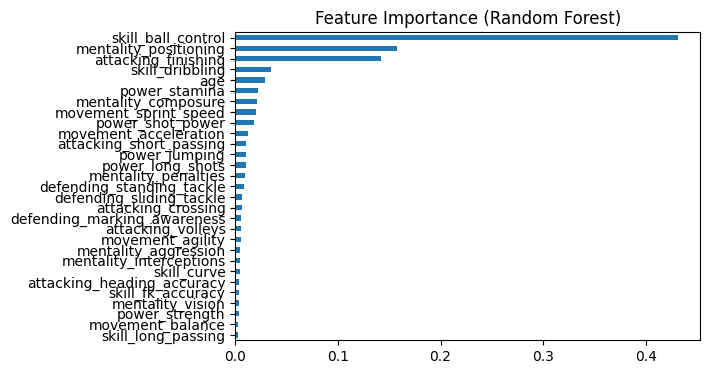

In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
model = RandomForestRegressor(n_estimators=200, random_state=42)
attacker_X_train, attacker_X_test, attacker_y_train, attacker_y_test = train_test_split(attacker_scaled_X, attacker_y, test_size=0.2, random_state=42)


selected_features = outfield_features#pca_selected_features + corr_features
model.fit(attacker_X_train[selected_features], attacker_y_train)

attacker_y_pred = model.predict(attacker_X_test[selected_features])

mae = mean_absolute_error(attacker_y_test, attacker_y_pred)
mse = mean_squared_error(attacker_y_test, attacker_y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(attacker_y_test, attacker_y_pred)

print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score, of test against pred: {r2:.4f}")

train_r2 = model.score(attacker_X_train[selected_features], attacker_y_train)
test_r2  = model.score(attacker_X_test[selected_features], attacker_y_test)

print(f"Train R²: {train_r2:.4f}")
print(f"Test  R²: {test_r2:.4f}")
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=attacker_scaled_X[selected_features].columns)
importances.sort_values().plot(kind="barh", figsize=(6,4))
plt.title("Feature Importance (Random Forest)")
plt.show()

In [95]:
a2_features = list(importance.head(10).index)

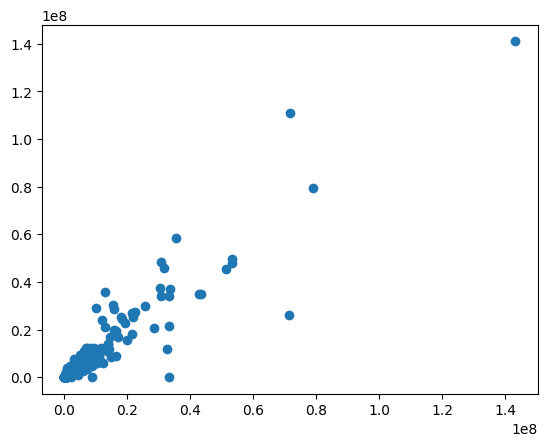

In [49]:
plt.scatter(attacker_y_pred, attacker_y_test)

In [104]:
# Split up dataframe based on position_group
# See the most important features
# Choosing the features

#### MIDFIELDERS

#### DEFENDERS

#### GOALKEEPERS

In [ ]:
gk_mask = df['primary_position'] == 'GK'
gk_df = df[gk_mask]
X = gk_df[gk_features]
y = gk_df['value_eur']

# MinMax scale numerical features
mm_scaler = MinMaxScaler()
X_scaled = pd.DataFrame(mm_scaler.fit_transform(X), columns=X.columns)


#  MODELS

Model Performance:
Mean Absolute Error (MAE): 365054.54
Mean Squared Error (MSE): 1703606251788.80
Root Mean Squared Error (RMSE): 1305222.68
R² Score, of test against pred: 0.9428
Train R²: 0.9756
Test  R²: 0.9428


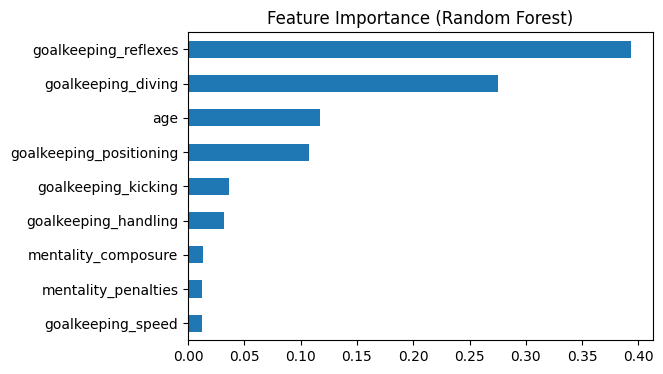

In [100]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200, random_state=42)
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
# Use regression metrics instead of classification metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Calculate regression metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score, of test against pred: {r2:.4f}")

train_r2 = model.score(X_train, y_train)
test_r2  = model.score(X_test, y_test)

print(f"Train R²: {train_r2:.4f}")
print(f"Test  R²: {test_r2:.4f}")
import pandas as pd
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=X_scaled.columns)
importances.sort_values().plot(kind="barh", figsize=(6,4))
plt.title("Feature Importance (Random Forest)")
plt.show()

In [ ]:
# Checking with new inputs from the user
# Method 1: Create sample new player data
def create_sample_player():
    """Create a sample player with realistic attributes"""

    # Get the feature names used in training
    feature_columns = X_train.select_dtypes(exclude=['object']).columns.tolist()

    # Create sample player data (you can modify these values)
    new_player_data = {
        'overall': 99,
        'potential': 99,
        'pace': 99,
        'shooting': 99,
        'passing': 99,
        'dribbling': 99,
        'defending': 99,
        'physic': 99
        }

    # Create DataFrame with all required features
    new_player_df = pd.DataFrame([new_player_data])

    # Ensure all training features are present (fill missing with median values)
    for col in feature_columns:
        if col not in new_player_df.columns:
            new_player_df[col] = X_train[col].median()

    # Reorder columns to match training data
    new_player_df = new_player_df[feature_columns]

    return new_player_df
# Create sample player
new_player = create_sample_player()
new_player
new_player_scaled = Robust_sc.transform(new_player)
new_player_scaled
# Make prediction
predicted_price = model.predict(new_player_scaled)
price = predicted_price[0]
formatted_price = f"{price:,.0f} EURO"
print(formatted_price)
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()

NameError: name 'Robust_sc' is not defined

In [102]:
df4

,overall,potential,value_eur,age,height_cm,weight_kg,league_level,club_jersey_number,nationality_id,nation_team_id,...,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb,gk
9,85,85,26000000,34,176,67,1.0,7.0,18,NaN,...,76,76,76,77,75,70,70,70,75,24
12,87,90,107000000,25,170,71,1.0,19.0,52,1369.0,...,75,75,75,75,73,69,69,69,73,21
29,88,90,118500000,23,178,65,1.0,7.0,14,1318.0,...,77,77,77,80,77,68,68,68,77,21
33,90,90,122500000,28,178,67,1.0,10.0,18,1335.0,...,71,71,71,74,70,63,63,63,70,21
36,88,88,99000000,27,174,72,1.0,10.0,52,1369.0,...,71,71,71,71,69,67,67,67,69,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16633,50,72,150000,18,188,80,1.0,46.0,95,NaN,...,30,30,30,34,33,29,29,29,33,17
16639,48,61,120000,21,173,65,1.0,29.0,159,NaN,...,32,32,32,34,33,31,31,31,33,14
16673,49,57,100000,23,185,68,1.0,35.0,18,NaN,...,31,31,31,34,33,28,28,28,33,19
16680,48,73,150000,17,185,67,1.0,29.0,145,NaN,...,32,32,32,35,34,30,30,30,34,18
